In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
from glob import glob

import torchvision.transforms as T
from torchvision.datasets.cifar import CIFAR10
from torch.utils.data import DataLoader, Subset
import numpy as np
from torch.nn.parallel import DataParallel
from resnet import ResNet18, ResNet34, ResNet50

In [2]:
class BaseDataset(data.Dataset):
    """docstring for BaseDataset"""

    def __init__(self, config):
        super(BaseDataset, self).__init__()
        self.format = config["format"]
        self.set_filepaths(config["path"])
        self.device = config["device"]

    def set_filepaths(self, path):
        filepaths = path + "/*{}".format(self.format)
        self.filepaths = glob(filepaths)

    def load_batch(self, filepath):
        inp, out = torch.load(filepath, map_location=self.device)
        return inp, out

    def __getitem__(self, index):
        filepath = self.filepaths[index]
        inp, out = self.load_batch(filepath)
        out = nn.functional.log_softmax(out, dim=1)
        return inp, out

    def __len__(self):
        return len(self.filepaths)

In [3]:
def get_model(model_name:str, dset:str, device:torch.device, device_ids:list) -> DataParallel:
        #TODO: add support for loading checkpointed models
        channels = 3 if dset=="cifar10" else 1
        model_name = model_name.lower()
        if model_name == "resnet18":
            model = ResNet18(channels)
        elif model_name == "resnet34":
            model = ResNet34(channels)
        elif model_name == "resnet50":
            model = ResNet50(channels)
        else:
            raise ValueError(f"Model name {model_name} not supported")
        model = DataParallel(model.to(device), device_ids=device_ids)
        return model

In [4]:
def test(model, dloader, loss_fn, device, **kwargs):
        """TODO: generate docstring
        """
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in dloader:
                data, target = data.to(device), target.to(device)
                position = kwargs.get("position", 0)
                output = model(data, position=position)
                test_loss += loss_fn(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                # view_as() is used to make sure the shape of pred and target are the same
                correct += pred.eq(target.view_as(pred)).sum().item()
        acc = correct / len(dloader.dataset)
        return test_loss, acc

In [5]:
def train(model:nn.Module, optim, dloader, loss_fn, device: torch.device, **kwargs):
        """TODO: generate docstring
        """
        model.train()
        train_loss = 0
        correct = 0
        for batch_idx, (data, target) in enumerate(dloader):
            data, target = data.to(device)[0], target.to(device)[0]
            optim.zero_grad()
            position = kwargs.get("position", 0)
            output = model(data, position=position)
            if kwargs.get("apply_softmax", False):
                output = nn.functional.log_softmax(output, dim=1) # type: ignore
            loss = loss_fn(output, target)
            loss.backward()
            optim.step()
            train_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            # view_as() is used to make sure the shape of pred and target are the same
            if len(target.size()) > 1:
                target = target.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        acc = correct / (len(dloader.dataset) * 128)
        return train_loss, acc

In [6]:
device = torch.device('cuda')

In [7]:
fedavg_data_config = {
    "format": "*_node.pt",
    "path": "../expt_dump/iid_clients_distill_reps_cifar10_4clients_6000samples_fedavg_distill_epochs_10_global_steps_400_local_steps_5_position_0_warmup_250_inversion_algo_send_grads_adaptive_distill_False_seed2/logs",
    "device": device
}

fedadam_data_config = {
    "format": "*_node.pt",
    "path": "../expt_dump/iid_clients_distill_reps_cifar10_4clients_6000samples_fedadam_distill_epochs_10_global_steps_400_local_steps_5_position_0_warmup_250_inversion_algo_send_grads_adaptive_distill_False_seed2/logs",
    "device": device
}

fedavg_dset = BaseDataset(fedavg_data_config)
fedadam_dset = BaseDataset(fedadam_data_config)
indices = np.random.permutation(len(fedavg_dset))[:112]
fedavg_dset = Subset(fedavg_dset, indices)
indices = np.random.permutation(len(fedadam_dset))[:112]
fedadam_dset = Subset(fedadam_dset, indices)


In [8]:
fedavg_train_loader = DataLoader(fedavg_dset, batch_size=1, shuffle=True)
fedadam_train_loader = DataLoader(fedadam_dset, batch_size=1, shuffle=True)

dpath = "../imgs/cifar10/"
mean = np.array((0.4914, 0.4822, 0.4465))
std = np.array((0.2023, 0.1994, 0.2010))
test_transform = T.Compose(
            [
                T.ToTensor(),
                T.Normalize(
                    mean, 
                    std
                ),
            ]
        )
test_dset = CIFAR10(root=dpath, train=False, download=False, transform=test_transform)
test_loader = DataLoader(test_dset, batch_size=256)

In [9]:
print(len(fedavg_dset))
print(len(fedadam_dset))
print(len(test_dset))

75
80
10000


In [10]:
# initialize a model
device_ids = [0,1,2,3]
device = torch.device(f'cuda:{device_ids[0]}')
fedavg_model = get_model("resnet34", "cifar10", device, device_ids)
fedavg_optim = torch.optim.Adam(fedavg_model.parameters(), lr=3e-4)
fedadam_model = get_model("resnet34", "cifar10", device, device_ids)
fedadam_optim = torch.optim.Adam(fedadam_model.parameters(), lr=3e-4)
loss_fn_ce = torch.nn.CrossEntropyLoss()
loss_fn_kl = nn.KLDivLoss(reduction="batchmean", log_target=True)

In [11]:
epochs = 100

fedavg_best_test_acc = 0
# test_acc_l112_ is node 3
test_acc_fedavg, tr_acc_fedavg = [], []
for epoch in range(epochs):
    test_loss, test_acc = test(fedavg_model, test_loader, loss_fn_ce, device)
    test_acc_fedavg.append(test_acc)
    if fedavg_best_test_acc < test_acc:
        fedavg_best_test_acc = test_acc
    tr_loss, tr_acc = train(fedavg_model, fedavg_optim, fedavg_train_loader, loss_fn_kl, device, apply_softmax=True)
    tr_acc_fedavg.append(tr_acc)
    print("epoch {} test_loss: {:.4f}, test_acc: {:.4f}, tr_loss: {:.4f}, tr_acc: {:.4f}".format(epoch,
                                                                                                 test_loss,
                                                                                                 test_acc,
                                                                                                 tr_loss,
                                                                                                 tr_acc))
    
fedadam_best_test_acc = 0
# test_acc_l112_ is node 3
test_acc_fedadam, tr_acc_fedadam = [], []
for epoch in range(epochs):
    test_loss, test_acc = test(fedadam_model, test_loader, loss_fn_ce, device)
    test_acc_fedadam.append(test_acc)
    if fedadam_best_test_acc < test_acc:
        fedadam_best_test_acc = test_acc
    tr_loss, tr_acc = train(fedadam_model, fedadam_optim, fedadam_train_loader, loss_fn_kl, device, apply_softmax=True)
    tr_acc_fedadam.append(tr_acc)
    print("epoch {} test_loss: {:.4f}, test_acc: {:.4f}, tr_loss: {:.4f}, tr_acc: {:.4f}".format(epoch,
                                                                                                 test_loss,
                                                                                                 test_acc,
                                                                                                 tr_loss,
                                                                                                 tr_acc))

epoch 0 test_loss: 92.1467, test_acc: 0.1000, tr_loss: 89.6688, tr_acc: 0.3584
epoch 1 test_loss: 156.9031, test_acc: 0.1176, tr_loss: 55.2790, tr_acc: 0.5536
epoch 2 test_loss: 129.5590, test_acc: 0.2046, tr_loss: 35.6339, tr_acc: 0.6813
epoch 3 test_loss: 112.0346, test_acc: 0.3110, tr_loss: 24.6510, tr_acc: 0.7707
epoch 4 test_loss: 157.3595, test_acc: 0.2480, tr_loss: 17.3977, tr_acc: 0.8345
epoch 5 test_loss: 110.1161, test_acc: 0.3025, tr_loss: 13.6273, tr_acc: 0.8498
epoch 6 test_loss: 98.2279, test_acc: 0.3443, tr_loss: 10.7870, tr_acc: 0.8875
epoch 7 test_loss: 117.7262, test_acc: 0.3033, tr_loss: 9.4331, tr_acc: 0.8835
epoch 8 test_loss: 110.8577, test_acc: 0.3027, tr_loss: 8.6486, tr_acc: 0.8932
epoch 9 test_loss: 108.5653, test_acc: 0.3096, tr_loss: 7.6487, tr_acc: 0.8951
epoch 10 test_loss: 115.8707, test_acc: 0.2817, tr_loss: 7.4337, tr_acc: 0.8927
epoch 11 test_loss: 124.4175, test_acc: 0.3262, tr_loss: 7.0017, tr_acc: 0.8986
epoch 12 test_loss: 115.2795, test_acc: 0.304

In [12]:
print(fedavg_best_test_acc )
print(fedadam_best_test_acc )

0.4131
0.5465


In [13]:
import matplotlib.pyplot as plt

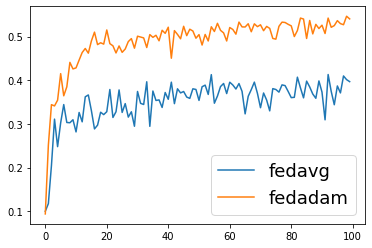

In [17]:
# plt.plot(test_acc_l)
plt.plot(test_acc_fedavg, label='fedavg')
plt.plot(test_acc_fedadam, label='fedadam')
plt.legend(fontsize=18)
plt.show()